# Grupo 5 - Word2Vec + RNN


## Sumário

- **1. Setup**

- **2. Carregamento e Preparação dos Dados**
  - **2.1 Carregamento dos dados**
  - **2.2 Preparação dos dados**
  - **2.3 Divisão dos dados**
  - **2.3 Divisão dos dados**
  - **2.4 Tokenização**
  - **2.5 Normalização**
  - **2.6 Categorizar Labels**

- **3. Word2Vec**

- **4. Rede Neural Classificação**
  - **4.1 Definição da rede neural**
  - **4.2 Treinamento da rede neural**

- **5. Resultados**
  - **5.1 Avaliação do modelo**
  - **5.2 Gráfico da variação da acurácia e loss de acordo com as épocas**
  - **5.3 Gráfico para comparação das métricas Recall X Precision X F1-Score**

- **6. Performance**


# 1. Setup

Seção para realizar a prepração do ambiente de desenvolvimento, realizando a conexão com o Google Drive e importando as bibliotecas necessárias.



In [114]:
# Montagem do drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
# Importar bibliotecas
import time
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models import KeyedVectors


# 2. Carregamento e Preparação dos Dados

Nesta seção é feito o carregamento da base de dados que está salva no drive compartilhado da turma, e fazendo todo o pré processamento dos dados, como separar em treino e teste, tokenizar, normalizar os paddings para utilizar no Word2Vector e transformando para número as intenções.

## 2.1 Carregamento dos Dados

In [116]:
# Carregar os dados
PATH = '/content/drive/Shareddrives/Grupo_05/baseTratada_v3_20240909.xlsx'
data = pd.read_excel(PATH)

In [117]:
# Exibir as primeiras linhas do dataset
data = data[['Intencao', 'Pergunta_Lematizada', 'Resposta_Lematizada']]
data.head()

,Intencao,Pergunta_Lematizada,Resposta_Lematizada
0,Como depositar,dia gostar caixa family mart verde eh hora tra...,dia senhor utilizar carto depsito mquino hora ...
1,Como fazer remessa,enviar dinheiro japo,inscrever servio remessar baixe aplicativo bra...
2,Tempo de remessa,levar beneficirio receber dinheiro,via regro remessa sero pago ver pix hora dado ...
3,"Pedido de envio via metodo ""ByPhone""",acabar transferncia total iene,ir processar solicitacao otimo
4,"Pedido de envio via metodo ""ByPhone""",poder remesso iene iene caixa econmic...,ir processar solicitacao otimo


## 2.2 Preparação dos dados

In [118]:
perguntas = data[['Intencao', 'Pergunta_Lematizada']].copy()
respostas = data[['Intencao', 'Resposta_Lematizada']].copy()
perguntas = perguntas.rename(columns={'Pergunta_Lematizada': 'Texto'})
respostas = respostas.rename(columns={'Resposta_Lematizada': 'Texto'})
base = pd.concat([perguntas,respostas])
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1564 entries, 0 to 781
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Intencao  1564 non-null   object
 1   Texto     1553 non-null   object
dtypes: object(2)
memory usage: 36.7+ KB


In [119]:
base = base.dropna()
base = base.drop_duplicates(subset='Texto')
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1156 entries, 0 to 781
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Intencao  1156 non-null   object
 1   Texto     1156 non-null   object
dtypes: object(2)
memory usage: 27.1+ KB


## 2.3 Divisão dos dados

In [120]:
# Definição de labels e dados que serão utilizados para o treinamento
quests = base['Texto'].astype(str).values
labels = base['Intencao'].values

In [121]:
# Dividir os dados em conjuntos de treinamento e teste sendo 75% e 25%
train_data, test_data, train_labels, test_labels = train_test_split(quests, labels, test_size=0.25, random_state=42)

## 2.4 Tokenização

In [122]:
# Tokenização das perguntas com um token OOV para palavras desconhecidas
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_data)  # Tokeniza o texto
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

In [123]:
# Visualizando as sequências geradas
print("Sequências de treino:", train_sequences)
print("Sequências de teste:", test_sequences)

Sequências de treino: [[34, 70, 308, 84, 8, 5, 104, 26], [16, 39], [49, 142, 416, 3, 21, 10, 11], [13, 195], [125, 417, 59, 196, 418, 508, 509, 687, 510, 511, 688, 512, 513, 689, 514], [42, 50, 309, 116, 12, 95, 197], [690, 691, 35, 195, 210, 108, 71, 692], [8, 39, 66, 40, 31, 47], [29, 41, 7, 14, 9, 34, 152, 34], [254, 7, 40, 92, 24, 40], [131, 34, 6, 30, 57], [37], [131, 515, 310, 277, 23, 153, 278], [131, 311, 73, 13, 279, 693, 20, 311, 6, 19, 143, 19, 43, 136, 13, 694, 62, 255, 311, 256, 197, 12, 57, 26, 516, 517, 73, 13, 62, 255, 173, 23, 126, 518, 695, 234, 20, 311, 14, 67, 12, 164, 6, 39, 696, 173, 174, 518, 519, 20, 312, 697, 698, 41, 312, 127, 32, 32, 183, 132, 73, 183, 132, 174, 22, 349, 419, 19, 37, 279, 144, 19, 37], [175, 29, 16, 4, 12, 119, 280, 350], [26, 30, 6], [2, 43, 699, 520, 52, 521, 517, 2, 198, 281, 2, 520, 420, 700, 53, 282, 522, 523, 522, 154, 701, 9, 38, 702, 53, 282, 313, 52, 199], [42, 23, 41, 7, 106, 254], [2, 125, 309, 137, 37, 183, 132, 524, 4, 71, 703], 

## 2.5 Normalização

In [124]:
# Padding para garantir que todas as sequências tenham o mesmo comprimento
max_seq_length = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_seq_length, padding='post')

## 2.6 Categorizar as labels

In [125]:
# Codificação das labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [126]:
# Conversão para categórico
train_labels_categorical = to_categorical(train_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)

# 3. Word2Vec

Word2Vec é uma técnica de aprendizado de máquina que transforma palavras em vetores numéricos, capturando o significado semântico com base no contexto em que as palavras aparecem. Esses vetores permitem que palavras com significados semelhantes tenham representações semelhantes, facilitando o processamento de linguagem natural.

Word2Vec do NILC - Núcleo Interinstitucional de Linguística Computacional, na qual foi utilizado um WordEmbedding com 1000 dimensões.

In [127]:
Word2Vec = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/cbow_s1000.txt')

In [128]:
def vectorize_with_word2vec(sentences, tokenizer, embedding_dim=1000):
    """
    Vetoriza sentenças usando um modelo Word2Vec pré-treinado.

    Args:
        sentences (list of list of str): Lista de sentenças, onde cada sentença é uma lista de palavras.
        tokenizer (Tokenizer): Tokenizador usado para gerar o vocabulário e índices.
        embedding_dim (int): Dimensão dos embeddings. Default é 80.

    Returns:
        embedding_matrix (np.array): Matriz de embeddings.
        vocab_size (int): Tamanho do vocabulário.
    """
    # Obter o número total de palavras no vocabulário
    vocab_size = len(tokenizer.word_index) + 1

    # Criar a matriz de embeddings
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # Preencher a matriz de embeddings com os vetores do modelo Word2Vec
    for word, i in tokenizer.word_index.items():
        if word in Word2Vec:
            embedding_matrix[i] = Word2Vec[word]
        else:
            embedding_matrix[i] = np.random.normal(size=(embedding_dim,))  # Vetor aleatório para palavras desconhecidas

    return embedding_matrix, vocab_size

# Testes da função de vetorização
train_sentences = [text.split() for text in train_data]  # Converter as perguntas para listas de palavras

# Supondo que tokenizer já tenha sido criado e treinado
embedding_matrix, vocab_size = vectorize_with_word2vec(train_sentences, tokenizer, embedding_dim=300)

# 4. Rede Neural Classificação

Nesta seção foi construída a rede neural para a classificação de intenção a partir das perguntas que foram fornecida na base de dados, tendo os seguintes componentes:

- Embedding: Converte palavras em vetores usando pesos pré-treinados do Word2Vec, mantendo as representações das palavras fixas.

- Bidirectional LSTM: Camadas LSTM bidirecionais que capturam dependências temporais no texto, considerando o contexto dos dois lados.

- Global Max Pooling: Reduz a dimensão dos vetores de saída das LSTMs, mantendo o valor máximo em cada dimensão.

- Densas e Dropout: Camadas densas para modelar relações complexas com ativação ReLU e Dropout para evitar overfitting.

- Saída Softmax: Gera probabilidades para cada classe, usando a função softmax.

 Já para a otimização foi utilizada a rmsprop, sendo um algoritmo que ajusta os pesos do modelo adaptando a taxa de aprendizado com base nas gradientes passadas, melhorando a convergência. Na perda categorical_crossentropy que mede a diferença entre as previsões do modelo e as classes verdadeiras em problemas de classificação múltipla. E para avaliação a acurácia que calcula a proporção de previsões corretas em relação ao total de previsões feitas pelo modelo.


## 4.1 Definição da rede neural

In [129]:
def train_neural_network(train_padded, train_labels_categorical, vocab_size, embedding_matrix, max_seq_length, output_classes, epochs=500, batch_size=128):
    """
    Treina um classificador de Rede Neural utilizando LSTM bidirecional e embeddings Word2Vec.

    Args:
        train_padded (np.array): Dados de treinamento com padding aplicado.
        train_labels_categorical (np.array): Labels de treinamento em formato categórico.
        vocab_size (int): Tamanho do vocabulário.
        embedding_matrix (np.array): Matriz de embeddings.
        max_seq_length (int): Tamanho máximo da sequência.
        output_classes (int): Número de classes de saída.
        epochs (int): Número de épocas para treinamento. Default é 500.
        batch_size (int): Tamanho do batch. Default é 128.

    Returns:
        model (Sequential): Modelo treinado.
        history (History): Histórico de treinamento.
        elapsed_time (float): Tempo decorrido durante o treinamento.
        memory_usage (float): Uso de memória durante o treinamento em MB.
    """
    model = Sequential([
      Embedding(input_dim=vocab_size, output_dim=1000, weights=[embedding_matrix], input_length=max_seq_length, trainable=False),
      Bidirectional(LSTM(128)),
      Dropout(0.5),
      Dense(64, activation='relu'),
      Dropout(0.5),
      Dense(output_classes, activation='softmax')
    ])


    model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    start_time = time.time()
    history = model.fit(train_padded, train_labels_categorical, epochs=epochs, validation_data=(test_padded, test_labels_categorical), batch_size=batch_size, callbacks=[early_stopping])
    end_time = time.time()
    elapsed_time = end_time - start_time

    process = psutil.Process()
    memory_usage = process.memory_info().rss / (1024 * 1024)  # Converter para MB

    return model, history, elapsed_time, memory_usage

## 4.2 Treinamento da rede neural

Para o treinamento da rede neural, foi adicionado os dados de treino e teste que foram pré processados, para esta rede foi utilizada 500 épocas e um batch de 128. Foi adicionado também o early-stopping para evitar que o modelo tenha overfitting

In [130]:
# Testes da função de treinamento
model, history, elapsed_time, memory_usage = train_neural_network(train_padded, train_labels_categorical, vocab_size, embedding_matrix, max_seq_length, len(label_encoder.classes_))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ ?                           │         368,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 368,700 (1.41 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 368,700 (1.41 MB)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.0689 - loss: 3.0684 - val_accuracy: 0.1834 - val_loss: 2.9761
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2089 - loss: 2.8997 - val_accuracy: 0.1799 - val_loss: 2.7290
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2241 - loss: 2.7411 - val_accuracy: 0.2042 - val_loss: 2.6582
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2807 - loss: 2.5269 - val_accuracy: 0.2803 - val_loss: 2.4819
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3256 - loss: 2.4292 - val_accuracy: 0.3564 - val_loss: 2.4248
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3506 - loss: 2.3163 - val_accuracy: 0.3080 - val_loss: 2.5138
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3445 - loss: 2.2813 - val_accuracy: 0.3253 - val_loss: 2.2907
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3930 - loss: 2.1879 - val_accuracy: 0.3668 - val_loss

# 5. Resultados

Para avaliação do modelo enquanto ele treina foi utilizado a acurácia, pois ela define quanto que o modelo está acertando do total, sendo a mais útil para o atual modelo. Também foi acrescentado outras métricas como Recall, Precision e F1-Score.

**Explicação de cada métrica:**

- Acurácia: Fornece uma visão geral da performance do modelo, indicando o quão bem ele está acertando as previsões em geral.

- Recall: Foca em quantos dos verdadeiros positivos foram identificados, importante quando é crucial capturar todos os casos positivos.

- Precision: Avalia a qualidade das previsões positivas feitas pelo modelo, relevante quando é necessário evitar falsos positivos.

- F1-Score: Oferece uma métrica balanceada que considera tanto a precisão quanto o recall, útil para cenários onde ambos os aspectos são importantes.


## 5.1 Avaliação do modelo

O resultado do modelo para cada métrica foi:

- Acurácia: 50%
- Loss: 1.73
- Precisão: 46%
- Recall: 50%
- F1-Score: 44%




In [131]:
loss, accuracy = model.evaluate(test_padded, test_labels_categorical)
print(f'Test Accuracy: {accuracy:.2f}')
print(f'Loss: {loss:.2f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4605 - loss: 1.9240
Test Accuracy: 0.45
Loss: 1.95


In [132]:
# Previsões
predictions = model.predict(test_padded)
pred_labels = predictions.argmax(axis=1)
true_labels = test_labels_categorical.argmax(axis=1)

# Cálculo das métricas
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print('\n Métricas')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 Métricas
Precision: 0.42
Recall: 0.45
F1-Score: 0.39


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5.2 Gráfico de variação da acurácia e loss de acordo com as épocas

A partir desse gráfico percebe-se que o modelo está tendo um Overfitting, pois a validação flutua muito, então os dados treinados estão sendo muito específico, isso pode ser causado pela baixa quantidade de dados e também com a distribuição de categorias que algumas tem muito mais que outras

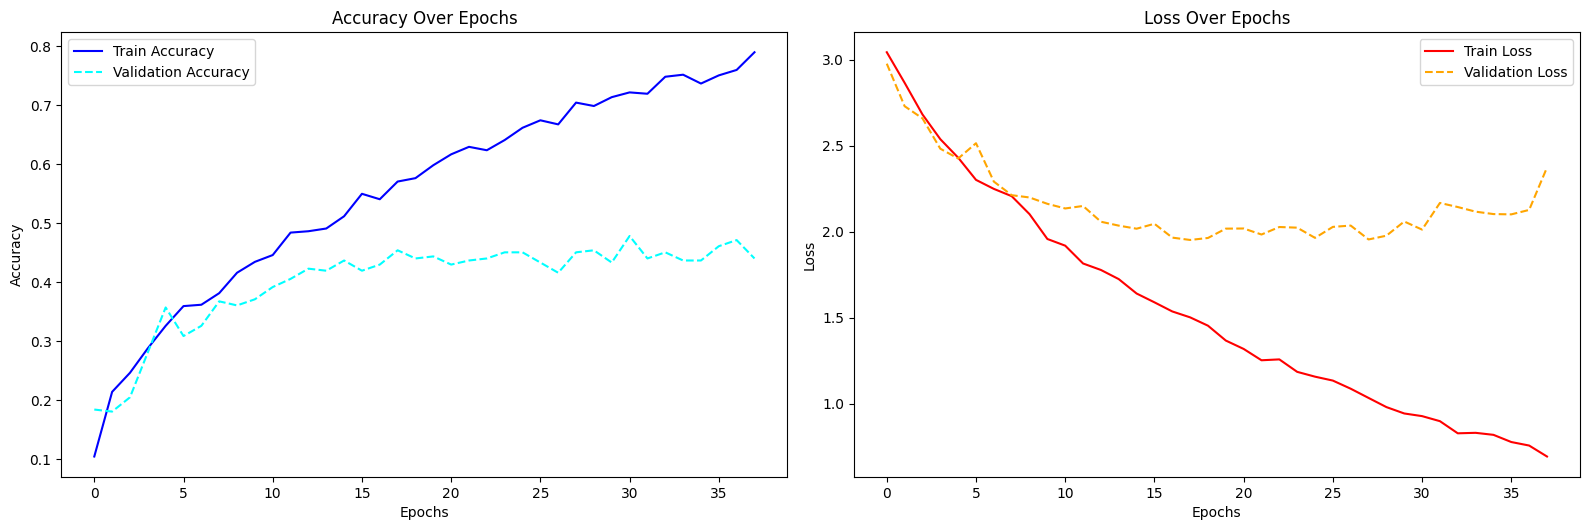

In [133]:
# Layout 2x2 para gráficos temporais
plt.figure(figsize=(16, 10))

# Gráfico de Acurácia
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Gráfico de Perda
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## 5.3 Gráfico para comparação das métricas Recall X Precision X F1-Score

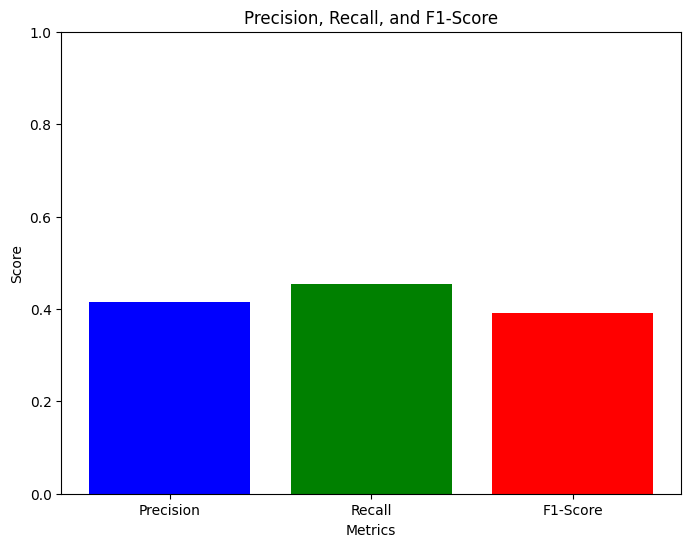

In [134]:
# Gráfico de Barras para as Métricas
metrics = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Precision, Recall, and F1-Score')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.show()


## 5.4 Matriz de Confusão

A partir da matriz de confusão se evidencia que o modelo está muito específico, pois para algumas labels ele acerta quase sempre, enquanto as outras labels não acertam nenhuma.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


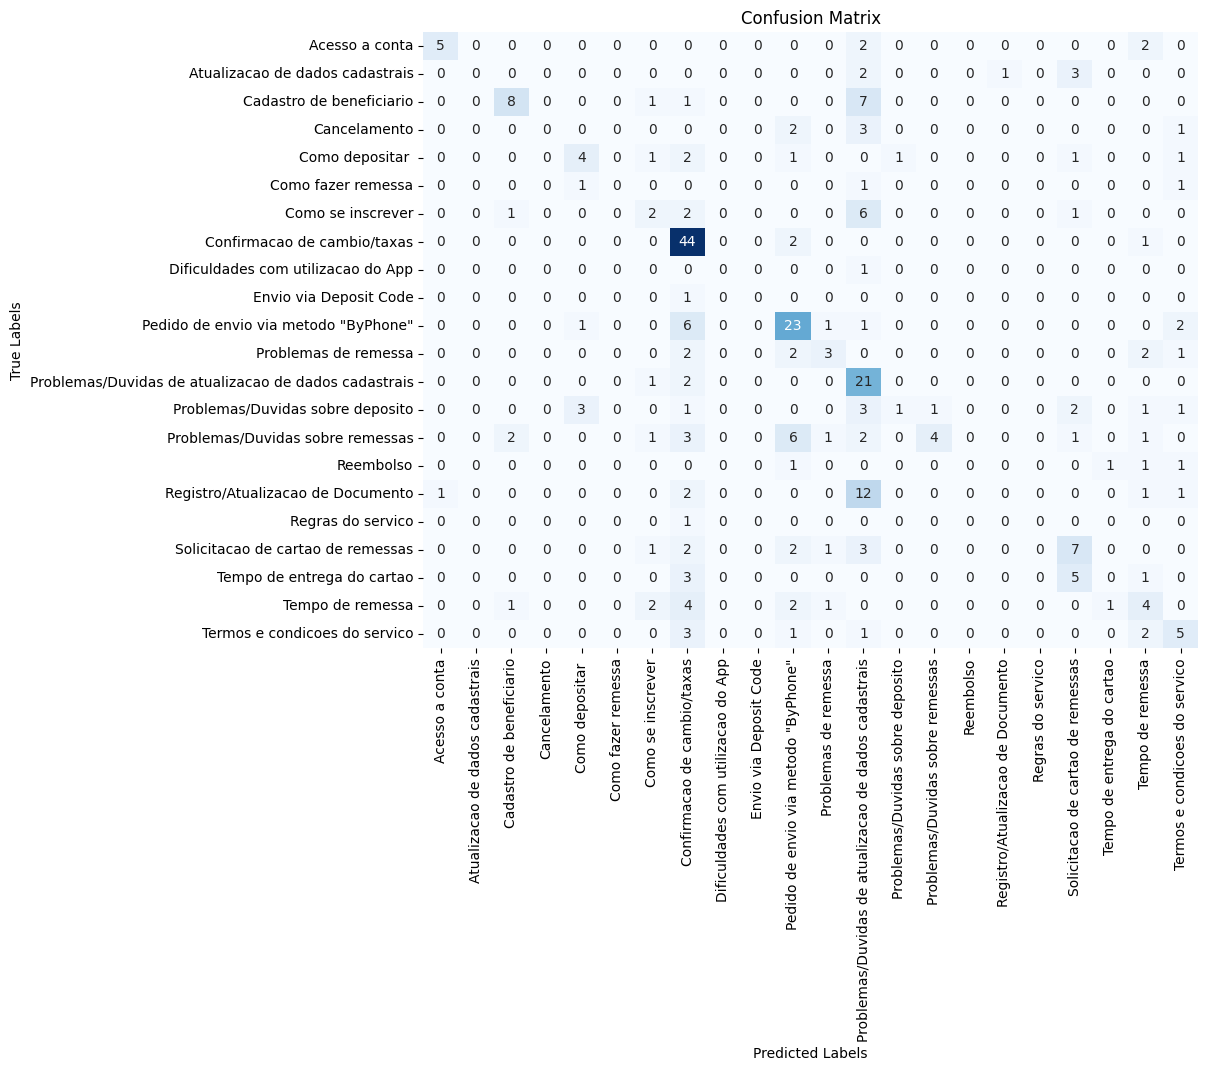

In [135]:
# Passo 1: Faça as previsões
predictions = model.predict(test_padded)
pred_labels = predictions.argmax(axis=1)
true_labels = test_labels_categorical.argmax(axis=1)

# Passo 2: Gere a matriz de confusão
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Passo 3: Mapeamento de índices para rótulos
label_mapping = dict(enumerate(label_encoder.classes_))
labels = list(label_mapping.values())

# Passo 4: Visualize a matriz de confusão com rótulos de classes
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')  # Ajuste a resolução e a margem
plt.show()

# 6. Performance

A CPU utiliza menos memória enquanto a GPU é muito mais rápida.

GPU
- TEMPO: 74.32 SEGUNDOS
- MEMORIA: 4939.39 MB

-----------

CPU
- TEMPO: 1243.25 SEGUNDOS
- MEMORIA: 1019.34MB

In [136]:
# Salvando o tempo de processamento e a memória utilizada
metrics_info = {
    "elapsed_time": elapsed_time,
    "memory_usage": memory_usage
}

print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")


Elapsed Time: 14.16 seconds
Memory Usage: 2795.25 MB
